# Transfer Learning

## Loading Libraries

In [ ]:
#Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib
import matplotlib_inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches

# Dataset's Iteration Performance
from tqdm import tqdm

# Time
import time

# OS
import re
import sys
import json
import string
import unicodedata
from glob import glob
from PIL import Image 
from io import BytesIO
from imageio import imread
from zipfile import ZipFile
import requests, zipfile, io
from collections import Counter 
from urllib.request import urlopen


# Warnings 
import warnings
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

# SciPy
from scipy.signal import convolve

# PyTorch
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import *
from torchvision.ops import nms
import torch.nn.functional as F
from torchvision import transforms
# from torchtext.datasets import AG_NEWS
# from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


# IDLMAM Libraries
from idlmam import moveTo, run_epoch, set_seed, View, pad_and_pack
from idlmam import train_simple_network, set_seed, Flatten, weight_reset, train_network
from idlmam import LanguageNameDataset, pad_and_pack, EmbeddingPackable, LastTimeStep, LambdaLayer
from idlmam import AttentionAvg, GeneralScore, DotScore, AdditiveAttentionScore, ApplyAttention, getMaskByFill


# Scikit-Learn
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#  IPython Display
from IPython.display import Latex
from IPython.display import display_pdf
from IPython.display import set_matplotlib_formats

### Visualization Set-Up

In [ ]:
%matplotlib inline

matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')

### Setting Seeds & Device

In [ ]:
torch.backends.cudnn.deterministic=True

set_seed(42)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")  

## Transferring Model Parameters

### Retrieving & Setting Data Up

In [ ]:
data_url_zip = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

Snippet Iteration Improvements:

In [ ]:
# Download and extract the zip file
if not os.path.isdir('./data/PetImages'):
    resp = urlopen(data_url_zip)
    zipfile = ZipFile(BytesIO(resp.read()))
    zipfile.extractall(path='./data')

# Function to check if an image is corrupted
def is_image_corrupt(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify if the image is corrupted
        return False
    except (IOError, SyntaxError) as e:
        print(f"Corrupted file detected and removed: {file_path}")
        return True

# List of bad files and corrupted files to remove
bad_files = [
    './data/PetImages/Dog/11702.jpg',
    "./data/PetImages/Cat/666.jpg"
]

# Directories of images
image_dirs = ['./data/PetImages/Cat', './data/PetImages/Dog']

# Check if directories exist and add corrupted files to bad files list
for dir_path in image_dirs:
    if os.path.isdir(dir_path):
        for filename in os.listdir(dir_path):
            file_path = os.path.join(dir_path, filename)
            if is_image_corrupt(file_path):
                bad_files.append(file_path)

# Remove bad files
for f in bad_files:
    if os.path.isfile(f):
        os.remove(f)

Corrupted file detected and removed: ./data/PetImages/Cat/11816.jpg


In [ ]:
# data_url_zip = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

# # Downloading
# if not os.path.isdir('./data/PetImages'):
#     resp = urlopen(data_url_zip)
#     zipfile = ZipFile(BytesIO(resp.read()))
#     zipfile.extractall(path = './data')

# # Removing Bad Files
# bad_files = [
#     './data/PetImages/Dog/11702.jpg',
#     "./data/PetImages/Cat/666.jpg"
# ]
# for f in bad_files:
#     if os.path.isfile(f):
#         os.remove(f)

In [ ]:
# Load all images after cleaning the dataset
all_images = torchvision.datasets.ImageFolder("./data/PetImages", transform=transforms.Compose(
    [
        transforms.Resize(130),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
    ]))

# Split into training and test sets
train_size = int(len(all_images) * 0.8)

test_size = len(all_images) - train_size

In [ ]:
# all_images = torchvision.datasets.ImageFolder("./data/PetImages", transform=transforms.Compose(
#     [
#         transforms.Resize(130), 
#         transforms.CenterCrop(128), 
#         transforms.ToTensor(), 
#     ]))

# # Train Test Split
# train_size = int(len(all_images)*0.8) 

# test_size = len(all_images)-train_size 

In [ ]:
# Data Random split 
train_data, test_data = torch.utils.data.random_split(all_images, (train_size, test_size))

In [ ]:
# # Random Split
# train_data, test_data = torch.utils.data.random_split(all_images, (train_size, test_size)) 

In [ ]:
# Batch Size
B = 128

# Data Loader
train_loader = DataLoader(train_data, batch_size=B, shuffle=True)
test_loader = DataLoader(test_data, batch_size=B)

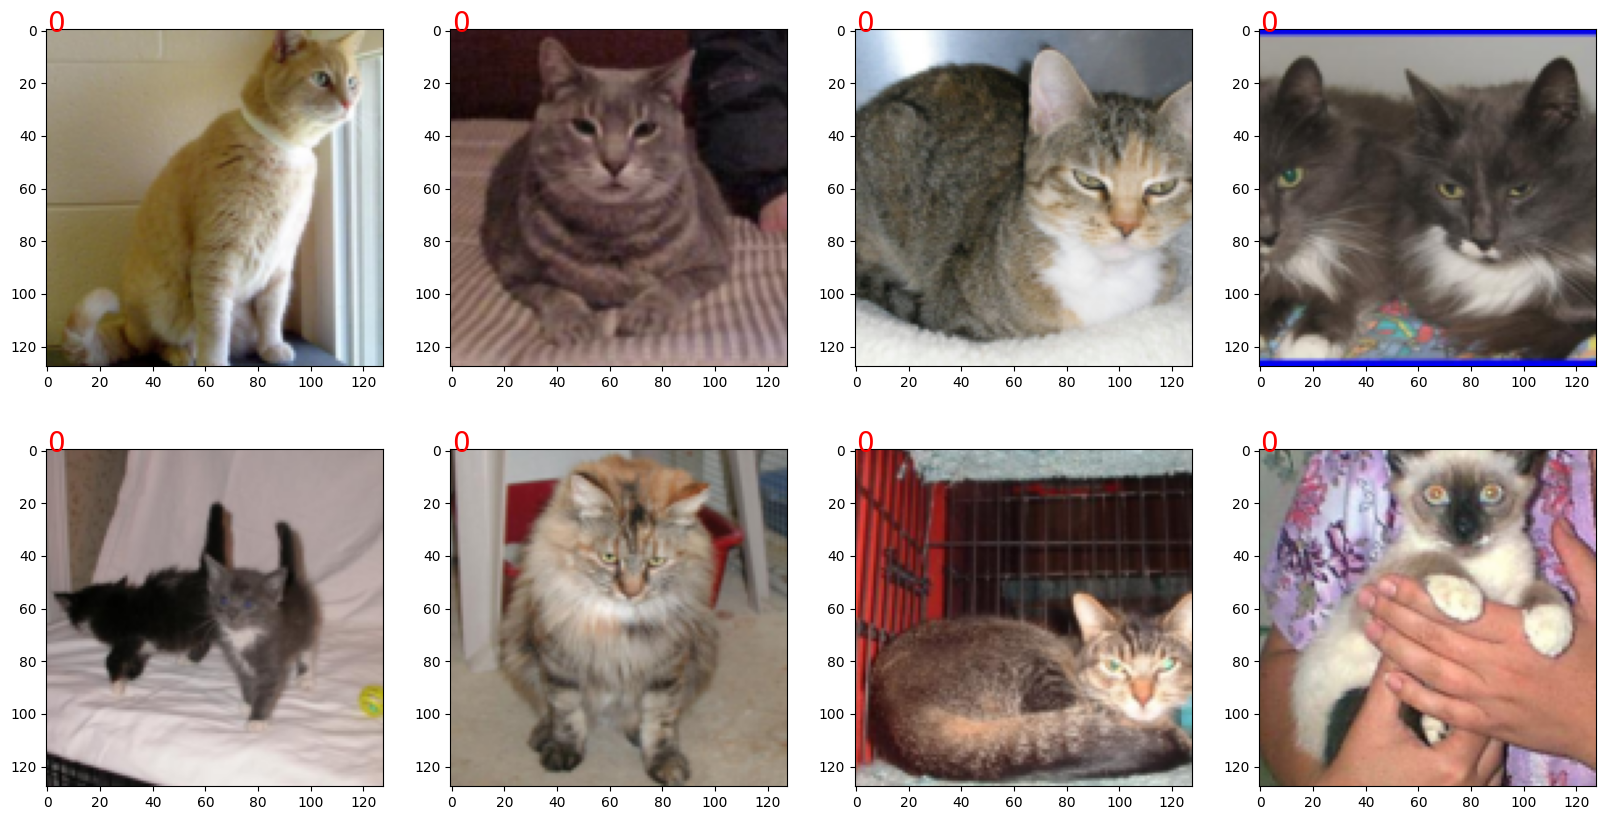

In [ ]:
f, axarr = plt.subplots(2,4, figsize=(20,10)) 

for i in range(2): 
    for j in range(4): 
        x, y = test_data[i*4+j] 
        axarr[i,j].imshow(x.numpy().transpose(1,2,0)) 
        axarr[i,j].text(0.0, 0.5, str(round(y,2)), dict(size=20, color='red'))

## Transfer Learning & Training with CNNs

In [ ]:
# ResNet18 Set-Up
model = torchvision.models.resnet18()

# Surgical Procedure
model.fc = nn.Linear(model.fc.in_features, 2)

In [ ]:
# Loss Fuction
loss = nn.CrossEntropyLoss()

In [ ]:
# Model Training
normal_results = train_network(model, 
loss, 
train_loader, 
epochs=10, 
device=device, 
test_loader=test_loader, 
score_funcs={'Accuracy': accuracy_score})

Training: 100%|██████████| 13/13 [03:13<00:00, 14.73s/it]
                                                         
Training: 100%|██████████| 13/13 [05:55<00:00, 25.24s/it]
                                                         
Training: 100%|██████████| 13/13 [06:29<00:00, 26.15s/it]
                                                         
Training:  38%|███▊      | 5/13 [02:22<03:44, 28.08s/it]

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
sns.lineplot(x='epoch', 
y='test Accuracy', 
data=normal_results, 
label='Regular')

plt.title('RestNet18 Model Training')
plt.grid(True)
plt.show()

### Adjusting PreTrained Parameters

In [ ]:
# Pretrained Model
model_pretrained = torchvision.models.resnet18(pretrained=True) 

# Surgical Adjustment
model_pretrained.fc = nn.Linear(model_pretrained.fc.in_features, 2)

In [ ]:
# 1st Conv Filter into Numpy Tensor
filters_pretrained = model_pretrained.conv1.weight.data.cpu().numpy() 

In [ ]:
# Shifting Range
filters_pretrained = filters_pretrained-np.min(filters_pretrained) 

# Rescaling
filters_pretrained = filters_pretrained/np.max(filters_pretrained)

In [ ]:
# Reallocating Image Dims
filters_pretrained = np.moveaxis(filters_pretrained, 1, -1)

In [ ]:
i_max = int(round(np.sqrt(filters_pretrained.shape[0]))) 
j_max = int(np.floor(filters_pretrained.shape[0]/float(i_max))) 

f, axarr = plt.subplots(i_max,j_max, figsize=(10,10)) 

for i in range(i_max): 
    for j in range(j_max): 
        indx = i*j_max+j 
        axarr[i,j].imshow(filters_pretrained[indx,:]) 
        axarr[i,j].set_axis_off() 

In [ ]:
def visualizeFilters(conv_filters):
    conv_filters = conv_filters-np.min(conv_filters)
    conv_filters = conv_filters/np.max(conv_filters)
    conv_filters = np.moveaxis(conv_filters, 1, -1)
    
    i_max = int(round(np.sqrt(conv_filters.shape[0])))
    j_max = int(np.floor(conv_filters.shape[0]/float(i_max)))
    f, axarr = plt.subplots(i_max,j_max, figsize=(10,10))
    for i in range(i_max):
        for j in range(j_max):
            indx = i*j_max+j
            axarr[i,j].imshow(conv_filters[indx,:])
            axarr[i,j].set_axis_off()

In [ ]:
filters_catdog = model.conv1.weight.data.cpu().numpy() 
visualizeFilters(filters_catdog) 

In [ ]:
class NormalizeInput(nn.Module):
    def __init__(self, baseModel):
        super(NormalizeInput, self).__init__()
        self.baseModel = baseModel 
        
        self.mean = nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1), requires_grad=False) 
        self.std = nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1), requires_grad=False)
    
    def forward(self, input):
        input = (input-self.mean)/self.std
        return self.baseModel(input)

In [ ]:
model_pretrained = NormalizeInput(model_pretrained)

### Training with Warm Stars

In [ ]:
warmstart_results = train_network(model_pretrained, 
loss, 
train_loader, 
epochs=10, 
device=device, 
test_loader=test_loader, 
score_funcs={'Accuracy': accuracy_score})

In [ ]:
# Regular Model
sns.lineplot(x='epoch', y='test Accuracy', data=normal_results, label='Regular')

# Warm Start
sns.lineplot(x='epoch', y='test Accuracy', data=warmstart_results, label='Warm')

plt.title('Regular vs. Warm StartModel')
plt.grid(True)
plt.show()

In [ ]:
filters_catdog_finetuned = model_pretrained.baseModel.conv1.weight.data.cpu().numpy() 
visualizeFilters(filters_catdog_finetuned) 

### Training with Frozen Weights

In [ ]:
#
model_frozen = torchvision.models.resnet18(pretrained=True)

# Freezing Parameters
for param in model_frozen.parameters():
    param.requires_grad = False

# Setting & Normilizing Model
model_frozen.fc = nn.Linear(model_frozen.fc.in_features, 2)

model_frozen = NormalizeInput(model_frozen)

Frozen Model Training:

In [ ]:
frozen_transfer_results = train_network(model_frozen, 
loss, 
train_loader, 
epochs=10, 
device=device, 
test_loader=test_loader, 
score_funcs={'Accuracy': accuracy_score})

In [ ]:
sns.lineplot(x='epoch', 
y='test Accuracy', 
data=normal_results, 
label='Regular')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=warmstart_results, 
label='Warm Start')

sns.lineplot(x='epoch', 
y='test Accuracy', 
data=frozen_transfer_results, 
label='Frozen')

plt.title('Regular vs. Warm Frozen Model')
plt.grid(True)
plt.show()

## Learning with Fewer Labels

In [ ]:
train_data_small, _ = torch.utils.data.random_split(train_data, (B*2,len(train_data)-B*2)) 

train_loader_small = DataLoader(train_data_small, batch_size=B, shuffle=True) 

In [ ]:
#1) Training from scratch
model = torchvision.models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 2)

normal_small_results = train_network(model, 
loss, 
train_loader_small, 
epochs=10, 
device=device, 
test_loader=test_loader, 
score_funcs={'Accuracy': accuracy_score})

In [ ]:
#2) Now lets train the warm model
model = torchvision.models.resnet18(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, 2) 

model = NormalizeInput(model)

warmstart_small_results = train_network(model, 
loss, 
train_loader_small, 
epochs=10, 
device=device, 
test_loader=test_loader, 
score_funcs={'Accuracy': accuracy_score})

In [ ]:
#3) Training with frozen weights
model = torchvision.models.resnet18(pretrained=True)


for param in model.parameters():
    param.requires_grad = False 


model.fc = nn.Linear(model.fc.in_features, 2)

model = NormalizeInput(model)

In [ ]:
frozen_transfer_small_results = train_network(model, loss, train_loader, epochs=10, device=device, test_loader=test_loader, score_funcs={'Accuracy': accuracy_score})

In [ ]:
sns.lineplot(x='epoch', y='test Accuracy', data=normal_small_results, label='Regular')

sns.lineplot(x='epoch', y='test Accuracy', data=warmstart_small_results, label='Warm Start')

sns.lineplot(x='epoch', y='test Accuracy', data=frozen_transfer_small_results, label='Frozen')

plt.title('2nd Regular vs. Warm Frozen Model')
plt.grid(True)
plt.show()

## Pretraining with Text

In [ ]:
!pip install torchtext 

!pip install sentencepiece 

!pip install transformers

In [ ]:
from torchtext.data.utils import get_tokenizer 
from collections import Counter 
from torchtext.vocab import Vocab 
import torchtext
from torchtext.datasets import text_classification
from transformers import DistilBertTokenizer, DistilBertModel 

In [ ]:
train_iter, test_iter = AG_NEWS(root='./data', split=('train', 'test'))

train_dataset_text = list(train_iter)

test_dataset_text = list(test_iter)


tokenizer = get_tokenizer('basic_english') 



counter = Counter() 

for (label, line) in train_dataset_text: 
    counter.update(tokenizer(line)) 

vocab = Vocab(counter, min_freq=10, specials=('<unk>', '<BOS>', '<EOS>', '<PAD>')) 

def text_transform(x): #string -> list of integers
    return [vocab['<BOS>']] + [vocab[token] for token in tokenizer(x)] + [vocab['<EOS>']] 

def label_transform(x): 
    return x-1 

VOCAB_SIZE = len(vocab)

NUN_CLASS = len(np.unique([z[0] for z in train_dataset_text]))

padding_idx = VOCAB_SIZE

VOCAB_SIZE += 1

In [ ]:


train_dataset_text, test_dataset_text = text_classification.DATASETS['AG_NEWS'](root="./data/", ngrams=1, vocab=None)

In [ ]:
train_data_text_small, _ = torch.utils.data.random_split(train_dataset_text, (256,len(train_dataset_text)-256)) 

In [ ]:
def pad_batch(batch):
    
    labels = [label_transform(z[0]) for z in batch]
    texts = [torch.tensor(text_transform(z[1]), dtype=torch.int64) for z in batch]
    
    max_len = max([text.size(0) for text in texts])
    
    PAD = padding_idx
    
    texts = [F.pad(text, (0,max_len-text.size(0)), value=PAD) for text in texts]
    
    x, y = torch.stack(texts), torch.tensor(labels, dtype=torch.int64)
    
    return x, y

In [ ]:
embed_dim = 128
gru = nn.Sequential(
  nn.Embedding(VOCAB_SIZE, embed_dim), 
  nn.GRU(embed_dim, embed_dim, num_layers=3, batch_first=True, bidirectional=True), 
  LastTimeStep(rnn_layers=3, bidirectional=True), 
  nn.Linear(embed_dim*2, NUN_CLASS), 
)

#Create train & test loader using this collate_fn
train_text_loader = DataLoader(train_data_text_small, batch_size=32, shuffle=True, collate_fn=pad_batch)

test_text_loader = DataLoader(test_dataset_text, batch_size=32, collate_fn=pad_batch)

In [ ]:
gru_results = train_network(gru, 
nn.CrossEntropyLoss(), 
train_text_loader, 
test_loader=test_text_loader, 
device=device, 
epochs=10, 
score_funcs={'Accuracy': accuracy_score})

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
def huggingface_batch(batch):
    labels = [label_transform(z[0]) for z in batch] 
    texts = [z[1] for z in batch] 
    
    texts = tokenizer.batch_encode_plus(texts, return_tensors='pt', padding=True)['input_ids']
    
    x, y = texts, torch.tensor(labels, dtype=torch.int64)
    return x, y

In [ ]:
train_text_bert_loader = DataLoader(train_data_text_small, batch_size=32, shuffle=True, collate_fn=huggingface_batch)

test_text_bert_loader = DataLoader(test_dataset_text, batch_size=32, collate_fn=huggingface_batch)

### Freezing Weights with No-Grad

In [ ]:
class BertBasedClassifier(nn.Module): 

    def __init__(self, bert_model, classes):
        
        super(BertBasedClassifier, self).__init__()
        self.bert_model = bert_model 
        self.attn = AttentionAvg(AdditiveAttentionScore(bert_model.config.dim)) 
        self.fc1 = nn.Linear(bert_model.config.dim, bert_model.config.dim)  
        self.pred = nn.Linear(bert_model.config.dim, classes) 
        
    
    def forward(self, input):
        mask = getMaskByFill(input)
        with torch.no_grad():
            x = self.bert_model(input)[0] 
        cntxt = x.sum(dim=1)/(mask.sum(dim=1).unsqueeze(1)+1e-5) 
        x = self.attn(x, cntxt, mask) 
        x = F.relu(self.fc1(x)) 
        return self.pred(x)

In [ ]:
bertClassifier = BertBasedClassifier(bert_model, NUN_CLASS) 

In [ ]:
bert_results = train_network(bertClassifier, nn.CrossEntropyLoss(), train_text_bert_loader, test_loader=test_text_bert_loader, device=device, epochs=10, score_funcs={'Accuracy': accuracy_score})

In [ ]:
sns.lineplot(x='epoch', y='test Accuracy', data=gru_results, label='Regular-GRU')
sns.lineplot(x='epoch', y='test Accuracy', data=bert_results, label='Frozen-BERT')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7b262bf3-85b2-4421-a448-4fe589bc864f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>